provenance des donnees : https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/4

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torchvision


# Data Exploration

In [2]:
path = "../../../DATA/License_Plate_Recognition/"

train_filenames = [name for name in os.listdir(path + "train/images/")]
test_filenames = [name for name in os.listdir(path + "test/images/")]
validation_filenames = [name for name in os.listdir(path+ "valid/images/")]

In [3]:
def recup_images (path, filenames):
    batch_size = len(filenames)
    data = torch.zeros(batch_size, 3, 640, 640, dtype=torch.uint8)
    for i, filename in enumerate(filenames):
        data[i] = torchvision.io.read_image(os.path.join(path, filename))
    return data

def recup_coordonnee (path, filename):
    f = open(path+filename[:-3]+'txt', 'r')
    contenu = f.read()
    f.close()
    return contenu.split(' ')

def prep_data (coor):
    data=[]
    d=[]
    for i in range (1, len(coor)):
        d.append(float(coor[i].split('\n')[0]))
        if len(d) == 4:
            data.append(d)
            d=[]
    return data

def recup_boxe (path, filenames):
    batch_size = len(filenames)
    data = []
    for i, filename in enumerate(filenames):
        coor = recup_coordonnee (path, filename)
        data.append(prep_data (coor))
    return data

In [ ]:
X_train = recup_images (path+'train/images/', train_filenames)
y_train = recup_boxe (path+'train/labels/', train_filenames)
X_test = recup_images (path+'test/images/', test_filenames)
y_test = recup_boxe (path+'test/labels/', test_filenames)
X_valid = recup_images (path+'valid/images/', validation_filenames)
y_valid = recup_boxe (path+'valid/labels/', validation_filenames)


In [ ]:
X_train = X_train.float()/255.0
X_test = X_test.float()/255.0
X_valid = X_valid.float()/255.0

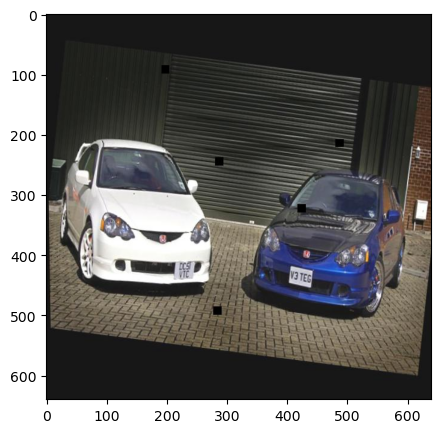

In [ ]:
fig = plt.figure(figsize=(8, 5))
plt.imshow(X_train[0].permute(1, 2, 0))